In [1]:
import pandas as pd
import json
import sys
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import boto3,os

from datasets.ppi_multiclass_label_mapper import PpiMulticlassLabelMapper

sys.path.append("../src")

from sklearn.metrics import plot_confusion_matrix

In [2]:
temp_dir = tempfile.mkdtemp()

s3_val_pred_ensemble_file ="s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert--10_2021050819/val_multiclass.json.json"
s3_test_pred_ensemble_file = "s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert--10_2021050819/test_multiclass.json.json"
label_mapper = PpiMulticlassLabelMapper()


In [3]:
def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
    return local_file

In [4]:
def load_output(data_file, label_mapper, input_data_file):
    
    with open(data_file, "r") as f:
        d = json.load(f)
    
    df = pd.DataFrame(d)


    score_type =  [ s["score_type"] for s in d[0]["result"]["scores"] ]
    for s in score_type:
        df[s] = df["result"].apply(lambda x: list(map(lambda k:k["score"], 
                                                      filter(lambda  k : k["score_type"]==s, x["scores"])))[0])

    df["loss"]= df["result"].apply(lambda x: x["loss"])
    
    df["raw_actual_pred_conf"] = df.apply(lambda x:  [(a,p,c) for a, p, c in zip(x["result"]["actual"],x["result"]["pred"], x["result"]["conf"])]
                                              , axis=1)

    
        
        
    df = df.explode("raw_actual_pred_conf", ignore_index=True)
    df[["actual", "prediction", "all_confidence_scores"]] = df.apply(lambda x : x["raw_actual_pred_conf"] , result_type="expand", axis=1)

    df["confidence"] = df["all_confidence_scores"].apply(max)


    df = df.drop("raw_actual_pred_conf", axis=1)

    df["correct"] = df["actual"] == df["prediction"]
    

    df["actual"] = df["actual"].apply( label_mapper.reverse_map)
    df["prediction"] = df["prediction"].apply( label_mapper.reverse_map)
    df["group_correct"] = df.apply(lambda x: is_group_correct(x["actual"], x["prediction"]) , axis=1)
    

    df_data = pd.read_json(input_data_file)


            
    return pd.concat([df_data, df], axis=1)

def is_group_correct(actual , predicted):
    neutral_map = {
        "phosphorylation" : "phos",
        "dephosphorylation" : "phos"

    }
    return neutral_map.get(actual , actual) == neutral_map.get(predicted , predicted) 
    
    
def load_ensemble_output(data_file):
    df = pd.read_json ( data_file)
    df = df.rename( columns= {
        "class" :"actual"
    })
    df["correct"] = df["actual"] == df["prediction"]
    df["group_correct"] = df.apply(lambda x: is_group_correct(x["actual"], x["prediction"]) , axis=1)
    
    return df

    

In [5]:
df_test_ensemble = load_ensemble_output ( download_file(s3_test_pred_ensemble_file, temp_dir))
# df_val_ensemble = load_ensemble_output ( download_file(s3_val_pred_ensemble_file, temp_dir))

In [6]:

df_test_ensemble.head(n=10)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,...,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,correct,group_correct
0,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q13315,Q12888,"{'472': ['Q13315', 'A0A024R3C7'], '7443': ['Q9...",...,0.019431,0.006155,0.003199,0.002869,0.002875,0.002184,other,0.963288,False,False
1,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q12888,Q99986,"{'472': ['Q13315', 'A0A024R3C7'], '7443': ['Q9...",...,0.244225,0.043271,0.015109,0.011628,0.013406,0.007888,other,0.664474,False,False
2,19864627,NF-kappaB is a key activator of inflammatory a...,"[{'start': '0', 'end': '9', 'name': 'NF-kappaB...",5,15,P19838 is a key activator of inflammatory and ...,"[{'charOffset': 0, 'len': 6, 'text': 'P19838'}...",Q8WTS6,Q04206,"{'7124': ['P01375', 'Q5STB3'], '80854': ['Q8WT...",...,0.355752,0.032139,0.023875,0.015226,0.017904,0.009611,other,0.545492,False,False
3,17974954,Src-specific activity has been reported to be ...,"[{'start': '0', 'end': '3', 'name': 'Src', 'ty...",6,26,P12931-specific activity has been reported to ...,"[{'charOffset': 0, 'len': 6, 'text': 'P12931'}...",P12931,P18031,"{'1445': ['P41240', 'B2R6Q4', 'A8K3B6'], '4888...",...,0.514597,0.119679,0.046598,0.033074,0.033184,0.025599,phosphorylation,0.514597,False,True
4,18243099,Maintenance of chromosomal stability relies on...,"[{'start': '168', 'end': '187', 'name': 'monop...",3,12,Maintenance of chromosomal stability relies on...,"[{'charOffset': 168, 'len': 6, 'text': 'P33981...",P33981,Q53HL2,"{'9212': ['Q96GD4'], '7272': ['P33981'], '5514...",...,0.495753,0.044914,0.027469,0.017931,0.021645,0.012250,phosphorylation,0.495753,True,True
5,20810653,The Slit-Robo GTPase-activating proteins (srGA...,"[{'start': '122', 'end': '127', 'name': 'Cdc42...",5,13,The Slit-Robo GTPase-activating proteins (srGA...,"[{'charOffset': 122, 'len': 6, 'text': 'P60953...",O14744,O75044,"{'23380': ['O75044', 'B7ZM87', 'B4DFE5', 'B7Z3...",...,0.615469,0.073138,0.051647,0.031221,0.032726,0.025052,phosphorylation,0.615469,False,False
6,20856200,The PI3K/AKT signaling pathway is aberrant in ...,"[{'start': '9', 'end': '12', 'name': 'AKT', 't...",2,15,The PI3K/P31749 signaling pathway is aberrant ...,"[{'charOffset': 9, 'len': 6, 'text': 'P31749'}...",P31749,P08670,"{'7431': ['P08670', 'V9HWE1'], '207': ['P31749...",...,0.581926,0.097979,0.064571,0.038733,0.037555,0.035260,phosphorylation,0.581926,True,True
7,20708153,Regulators of mitosis have been successfully t...,"[{'start': '121', 'end': '144', 'name': 'salt ...",3,10,Regulators of mitosis have been successfully t...,"[{'charOffset': 121, 'len': 6, 'text': 'Q9H0K1...",Q9BV73,Q9H0K1,"{'1078479': [], '23235': ['Q9H0K1', 'A0A024R3G...",...,0.606891,0.070893,0.050385,0.031638,0.032260,0.025797,phosphorylation,0.606891,True,True
8,16293623,The DNA damage-response regulators ATM (ataxia...,"[{'start': '35', 'end': '38', 'name': 'ATM', '...",4,32,The DNA damage-response regulators Q13315 (ata...,"[{'charOffset': 35, 'len': 6, 'text': 'Q13315'...",P16220,Q13535,"{'1385': ['P16220', 'Q5U0J5', 'Q53X93', 'B7Z5C...",...,0.075169,0.025019,0.011445,0.011184,0.011602,0.008560,other,0.857020,False,False
9,21658387,LRRK2 is the causal molecule for autosomal-dom...,"[{'start': '0', 'end': '5', 'name': 'LRRK2', '...",2,11,Q5S007 is the causal molecule for autosomal-do...,"[{'charOffset': 0, 'len': 6, 'text': 'Q5S007'}...",Q5S007,P31749,"{'120892': ['Q5S007', 'Q17RV3'], '207': ['P317...",..

In [7]:
(df_test_ensemble["prediction"] == df_test_ensemble ["actual"]).value_counts()

True     311
False     41
dtype: int64

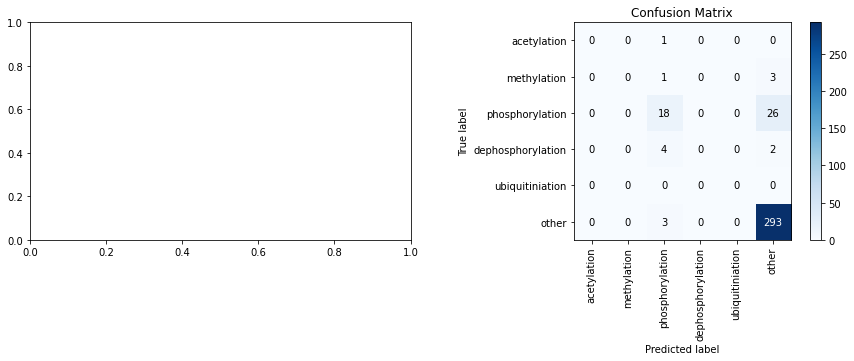

In [8]:
labels = ["acetylation", "methylation", "phosphorylation", "dephosphorylation", "ubiquitiniation", "other"]
fg, ax = plt.subplots(1,2, figsize=(15,4))
# skplt.metrics.plot_confusion_matrix(df_val_ensemble["actual"], df_val_ensemble["prediction"], 
#                                     labels=labels, normalize=False,x_tick_rotation=90, ax=ax[0], figsize=fg)

skplt.metrics.plot_confusion_matrix(df_test_ensemble["actual"], df_test_ensemble["prediction"],
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[1], figsize=fg)

plt.show()

In [9]:
df_test_ensemble.head()

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,...,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,correct,group_correct
0,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q13315,Q12888,"{'472': ['Q13315', 'A0A024R3C7'], '7443': ['Q9...",...,0.019431,0.006155,0.003199,0.002869,0.002875,0.002184,other,0.963288,False,False
1,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q12888,Q99986,"{'472': ['Q13315', 'A0A024R3C7'], '7443': ['Q9...",...,0.244225,0.043271,0.015109,0.011628,0.013406,0.007888,other,0.664474,False,False
2,19864627,NF-kappaB is a key activator of inflammatory a...,"[{'start': '0', 'end': '9', 'name': 'NF-kappaB...",5,15,P19838 is a key activator of inflammatory and ...,"[{'charOffset': 0, 'len': 6, 'text': 'P19838'}...",Q8WTS6,Q04206,"{'7124': ['P01375', 'Q5STB3'], '80854': ['Q8WT...",...,0.355752,0.032139,0.023875,0.015226,0.017904,0.009611,other,0.545492,False,False
3,17974954,Src-specific activity has been reported to be ...,"[{'start': '0', 'end': '3', 'name': 'Src', 'ty...",6,26,P12931-specific activity has been reported to ...,"[{'charOffset': 0, 'len': 6, 'text': 'P12931'}...",P12931,P18031,"{'1445': ['P41240', 'B2R6Q4', 'A8K3B6'], '4888...",...,0.514597,0.119679,0.046598,0.033074,0.033184,0.025599,phosphorylation,0.514597,False,True
4,18243099,Maintenance of chromosomal stability relies on...,"[{'start': '168', 'end': '187', 'name': 'monop...",3,12,Maintenance of chromosomal stability relies on...,"[{'charOffset': 168, 'len': 6, 'text': 'P33981...",P33981,Q53HL2,"{'9212': ['Q96GD4'], '7272': ['P33981'], '5514...",...,0.495753,0.044914,0.027469,0.017931,0.021645,0.012250,phosphorylation,0.495753,True,True


In [35]:
import numpy as np
import matplotlib.pyplot as plt

from scorers.result_scorer_ece import ResultScorerEce


class PlotReliability:

    def __init__(self, num_bins=10):
        self.num_bins = num_bins

    def plot(self, y_actual, y_pred_conf, *, ax_r=None, ax_c=None, **kwargs):
        
        # Get scorer
        scorer= ResultScorerEce()
        ece_error = round( scorer(y_actual, y_pred_conf),2)
        ece_values = scorer.get_bin_values(y_actual, y_pred_conf)
        
        # Get bin values
        bins = np.array(ece_values["bins"])
        expected_accuracy_bins=ece_values["expected_accuracy"]
        actual_accuracy_bins=np.array(ece_values["actual_accuracy"])
        conf_bins= np.array(ece_values["average_confidence"])
        num_items_in_bin=np.around( np.array(ece_values["num_items_in_bin"])/len(y_actual) ,decimals=2)
        
        avg_acc = np.mean(actual_accuracy_bins[~np.isnan(actual_accuracy_bins)])
        avg_conf = np.mean(conf_bins[~np.isnan(actual_accuracy_bins)])


            
        # Compute diff between expected vs actual
        diff = np.array(expected_accuracy_bins) - np.array(actual_accuracy_bins)
        under_expected = np.where(diff < 0, 0, diff)
        over_expected = np.where(diff > 0, 0, -1 * diff)
        
        # Start plotting
        ax_r = ax_r or plt.subplots(1, 1, figsize=(3, 3))[1]
        ax_c = ax_c or plt.subplots(1, 1, figsize=(3, 3))[1]
        
        ax_c.spines['bottom'].set_color('grey')
        ax_c.spines['top'].set_color('grey') 
        ax_c.spines['right'].set_color('grey')
        ax_c.spines['left'].set_color('grey')
        
        ax_r.spines['bottom'].set_color('grey')
        ax_r.spines['top'].set_color('grey') 
        ax_r.spines['right'].set_color('grey')
        ax_r.spines['left'].set_color('grey')

        bin_width = bins[1]-bins[0]
        
        
        # Plot confidence 
        ax_c.set_ylim([0,1])
        ax_c.set_xlim([0,1])
        ax_c.bar(bins[:-1], num_items_in_bin, width=bin_width, bottom=None, align='edge', color="deepskyblue",
                 edgecolor="white", data=None, **kwargs)
        
        ax_c.plot([avg_conf for i in range(0,10)], [i/10 for i in range(0,10)],'--', color="red", **kwargs, label="Average confidence"  )
        ax_c.plot([avg_acc for i in range(0,10)], [i/10 for i in range(0,10)],'--', color="blue", **kwargs, label="Average accuracy" )
       



        
        # Plot reliablity
        ax_r.set_ylim([0,1])
        ax_r.set_xlim([0,1])
        ax_r.bar(bins[:-1], expected_accuracy_bins, width=bin_width, bottom=None, align='edge', color="lightblue",
                 edgecolor="white", data=None, label="Expected accuracy", **kwargs)
        ax_r.bar(bins[:-1], under_expected, width=bin_width, bottom=expected_accuracy_bins, align='edge',
                 color="palevioletred", edgecolor="white", data=None, label="Gap", **kwargs)
        ax_r.bar(bins[:-1], over_expected, width=bin_width, bottom=expected_accuracy_bins, align='edge',
                 color="forestgreen", edgecolor="white", data=None, label="Above expected accuracy", **kwargs, )
        ax_r.plot( (bins[1:]+  bins[:-1])/2, expected_accuracy_bins, '--', color="red", data=None, **kwargs)






In [19]:
from netcal.metrics import ECE


from netcal.presentation import ReliabilityDiagram


def plot_classwise_conf_hist(df):
    
    pred_labels = list(df["prediction"].unique())
 
    sorted_labels = sorted (df["actual"].unique(), key=lambda x: label_mapper.map(x) )
    
    num_plots = len(pred_labels) + 1
    
    _, ax = plt.subplots(2, num_plots, figsize=(4*num_plots, 4*2))
    
    
    label_title_map = {"other" : "Negative class"}

    
    reliablity_plot = PlotReliability()
    for i,l in enumerate(pred_labels):
        df_label = df.query(f"prediction == '{l}'")
        
        actual_indices = df_label["actual"].apply(label_mapper.map)
        predicted_conf = df_label[sorted_labels]
        
        ax[0][i].set_title(label_title_map.get(l, l).title())
        reliablity_plot.plot(actual_indices, predicted_conf, ax_r= ax[0][i], ax_c=ax[1][i])
        
    
    actual_indices = df["actual"].apply(label_mapper.map)
    predicted_conf = df[sorted_labels]
        
    ax[0][-1].set_title("All")
    reliablity_plot.plot(actual_indices, predicted_conf, ax_r= ax[0][-1], ax_c=ax[1][-1])
    
    ax[1][-1].legend()
    ax[0][-1].legend()    
    return plt
    

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


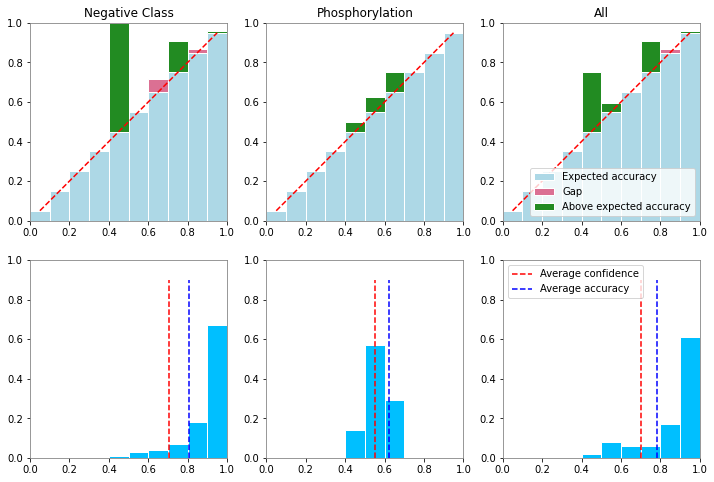

In [36]:
plt = plot_classwise_conf_hist(df_test_ensemble)
plt.savefig("reliability_test.pdf", bbox_inches="tight")